In [1]:
import numpy as np

import time

from sigvisa import Sigvisa
from sigvisa.source.event import get_event
from sigvisa.infer.coarse_to_fine_init import ModelSpec, EventRunSpec, do_coarse_to_fine, initialize_sg, initialize_from, do_inference
from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.treegp.gp import GPCov
from sigvisa.signals.io import load_event_station_chan
from sigvisa.models.joint_gp import multiply_scalar_gaussian
from sigvisa.utils.geog import dist_km_ev, dist_km

import os, sys, traceback
import cPickle as pickle

dbl1 = 9 #6
dbl2 = 17 #32


from sigvisa.learn.fit_shape_params_mcmc import compute_wavelet_messages
from sigvisa.learn.train_param_common import learn_gp, insert_model, load_model, get_model_fname, model_params
from sigvisa.database.signal_data import *
from sigvisa.plotting.event_heatmap import EventHeatmap


In [2]:
#with open("/home/dmoore/python/sigvisa/logs/mcmc/01962/step_000019/pickle.sg", 'rb') as f:
#    sg_joint = pickle.load(f)
with open("/home/dmoore/python/sigvisa/logs/mcmc/01963/step_000099/pickle.sg", 'rb') as f:
     sg_joint = pickle.load(f)

In [3]:
wn = sg_joint.get_arrival_wn("MK31", dbl1, "P", "freq_0.8_4.5", "BHZ")
gp_messages, gp_posteriors = compute_wavelet_messages(sg_joint, wn)

/home/dmoore/python/sigvisa/models/signal_model.py:572: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return TransientCombinedSSM(components, TSSM_NOISE_PADDING)


In [4]:
s = Sigvisa()
holdout_eid = dbl1
sta = "FITZ" #"AS12"#"MK31"
target_phase="P"
chan= "BHZ"
band="freq_0.8_4.5"

#wiggle_family = "db4_2.0_3_30.0"
wiggle_family = "db4_2.0_3_10.0"

# TODO: extract template fits and save to DB. this way 
# we can browse them in the usual way, 
# train GP models in the usual way, and save 
# training messages so that the web interafce 
# works properly. 
def extract_fits(sta, holdout_eid):
    X = []
    eids = []
    message_means = []
    message_vars = []
    posterior_means = []
    posterior_vars = []
    sta_loc = s.earthmodel.site_info(sta, 0)[:2]
    for wn in sg_joint.station_waves[sta]:
        chan = wn.chan
        #if wn.chan != chan or wn.band != band: continue
        gp_messages, gp_posteriors = compute_wavelet_messages(sg_joint, wn)
        for (eid, phase) in gp_messages.keys():
            if eid == holdout_eid: continue
            if phase != target_phase: continue

            eids.append(eid)
            gpm = gp_messages[(eid, phase)]
            gpp = gp_posteriors[(eid, phase)]
            message_means.append(gpm[0])
            message_vars.append(gpm[1])
            posterior_means.append(gpp[0])
            posterior_vars.append(gpp[1])

            ev = sg_joint.get_event(eid)
            X.append((ev.lon, ev.lat, ev.depth, ev.mb, dist_km((ev.lon, ev.lat), sta_loc)))
    X = np.array(X)
    return X, eids, message_means, message_vars, posterior_means, posterior_vars
X, eids, message_means, message_vars, posterior_means, posterior_vars = extract_fits("MK31", dbl1)

In [5]:
run_name = "aftershock_joint_P_10s" # "aftershock_joint_P"
#run_iter = 1
#cursor = s.dbconn.cursor()
#runid = get_fitting_runid(cursor, run_name, run_iter, create_if_new=True)

model_type = "gp_lld"
# TODO: properly track the number of coefs in the repeatable levels
n_coefs = len(message_means[0])
n_coefs_skipped = np.sum(wn.wavelet_basis[4][-sg_joint.skip_levels:])
n_coefs_modeled = n_coefs-n_coefs_skipped
print n_coefs, n_coefs_skipped, n_coefs_modeled

def build_gps(sta, nv, sv, ls, message_means, message_vars, X):
    targets = [wiggle_family + "_%d" % i for i in range(n_coefs_modeled)]
    cov_main = GPCov(wfn_str="matern32", wfn_params=[sv], dfn_str="lld", dfn_params=[ls, 20.0])
    gps = []
    for i in range(n_coefs_modeled):
        y = np.array([mm[i] for mm in message_means])
        yvars = np.array([mv[i] for mv in message_vars])
        target = targets[i]
        st = time.time()
        gp = learn_gp(X=X, y=y, y_obs_variances=yvars, sta=sta,
                      kernel_str="lld",
                      target=target, build_tree=False,
                      optimize=False, noise_var=nv, 
                      cov_main=cov_main)
        et = time.time()
        model = gp
        gps.append(gp)
    return gps
    
def build_gps_fromscratch(sta, nv, sv, ls, holdout_eid):
    X, eids, message_means, message_vars, posterior_means, posterior_vars = extract_fits(sta, holdout_eid=holdout_eid)
    gps = build_gps(sta, nv, sv, ls, message_means, message_vars, X)
    return gps

119 83 36


In [7]:
dbl2 = 17



def generate_heatmap(nv, sv, ls, sta, n=40, **kwargs):
    chan = sg_joint.station_waves[sta][0].chan
    wn = sg_joint.get_arrival_wn(sta, dbl1, "P", "freq_0.8_4.5", chan)

    hm, hp = compute_wavelet_messages(sg_joint, wn)
    holdout_posterior = hp.values()[0]
    holdout_messages = hm.values()[0]

    gps = build_gps_fromscratch(sta, nv, sv, ls, holdout_eid=dbl1)
    
    def gpll(lon, lat):
        X = np.array(([lon, lat, 0.0, 0.0, 0.0])).reshape((1, -1))
        ll = 0
        for i in range(n_coefs_modeled):
            gp = gps[i]
            posterior_mean, posterior_var = holdout_posterior[0][i], holdout_posterior[1][i]
            message_mean, message_var = holdout_messages[0][i], holdout_messages[1][i]

            m, v = gp.predict(X), gp.variance(X, include_obs=True)
            _, _, Z = multiply_scalar_gaussian(message_mean, message_var, m, v)
            Z = float(Z)
            #print i, Z

            ll += Z
        return ll
    
    hm = EventHeatmap(f=gpll, n=n, left_lon=128.8, right_lon=130.5, bottom_lat=-4.5, top_lat=-3.7, calc=True, **kwargs)

    return hm

evs = [sg_joint.get_event(eid) for eid in sorted(sg_joint.evnodes.keys()) if eid != dbl1]
locs = [(ev.lon, ev.lat) for ev in evs]
ev1 = sg_joint.get_event(dbl1)
loc1 = [(ev1.lon, ev1.lat) ]

def plot_hm(hm, **kwargs):
    f = plt.figure(figsize=(15, 15))
    ax = f.add_subplot(111)
    hm.plot(axes=ax, smooth= True, **kwargs)
    hm.plot_locations(locs, marker="o", ms=12,  yvals=None, alpha=1.0, mfc="gray")
    hm.plot_locations(loc1, marker="*", ms=24,  yvals=None, alpha=1.0, mfc="yellow")
    ax.set_title("")
    ax.axis("off")
    return ax

loading heat map values from ZAA080.map
loading heat map values from CM1680.map
could not combine event locations: need more than 0 values to unpack
could not combine event locations: need more than 0 values to unpack
could not combine event locations: need more than 0 values to unpack
"couldn't find wave node for eid 9 phase P at station AKTO chan BHZ band freq_0.8_4.5"
could not combine event locations: need more than 0 values to unpack
could not combine event locations: need more than 0 values to unpack
could not combine event locations: need more than 0 values to unpack
could not combine event locations: need more than 0 values to unpack
could not combine event locations: need more than 0 values to unpack
could not combine event locations: need more than 0 values to unpack
"couldn't find wave node for eid 9 phase P at station KURBB chan BHZ band freq_0.8_4.5"


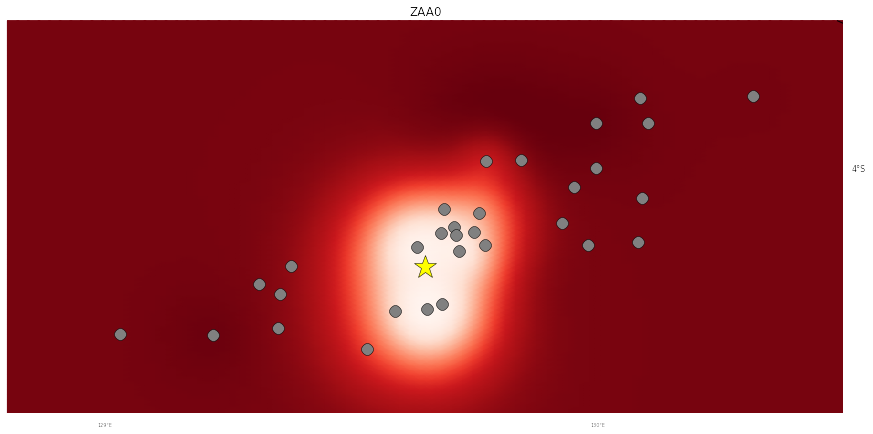

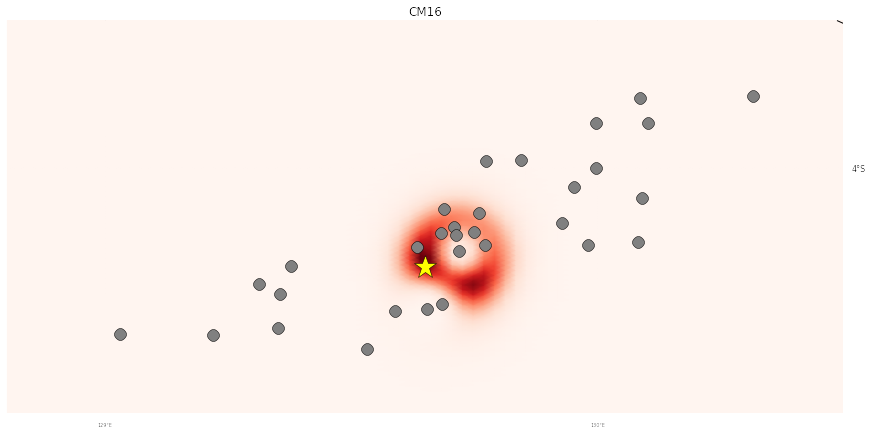

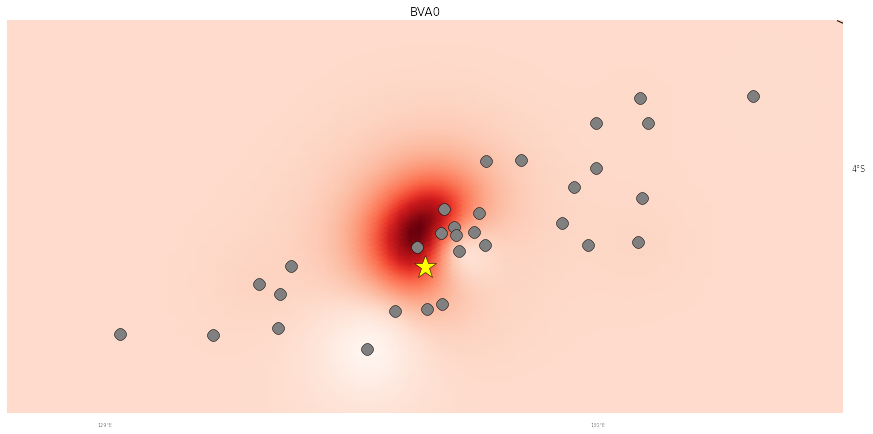

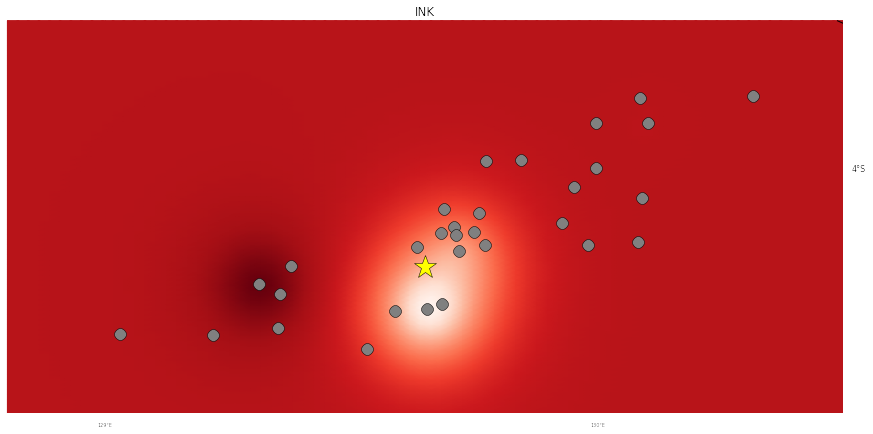

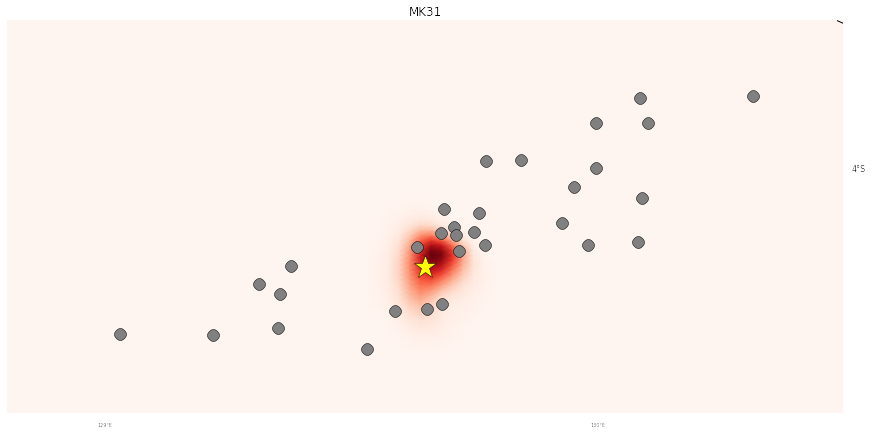

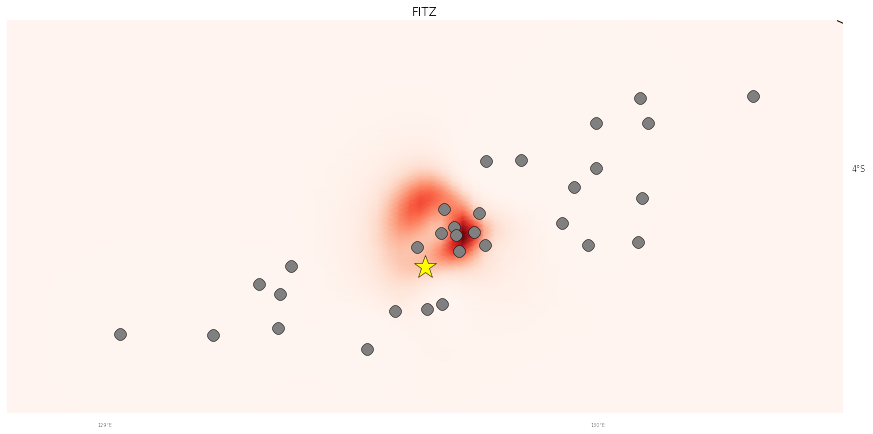

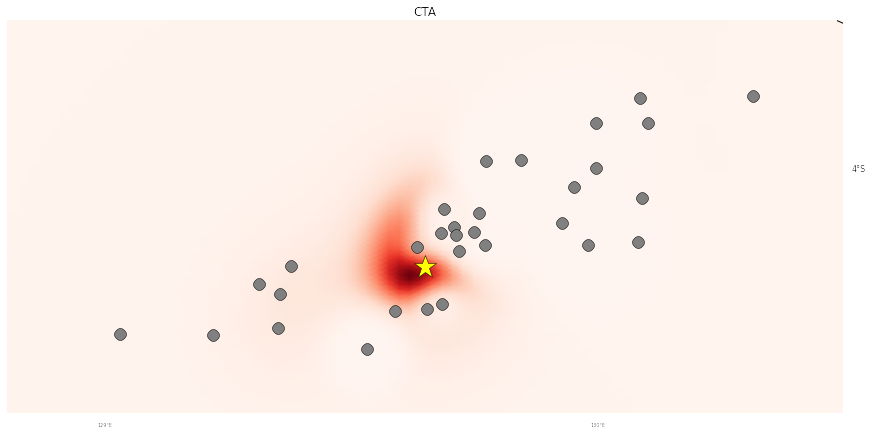

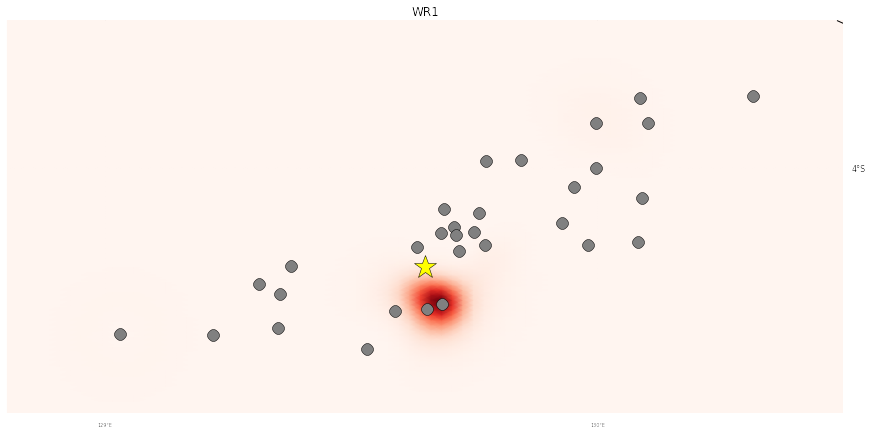

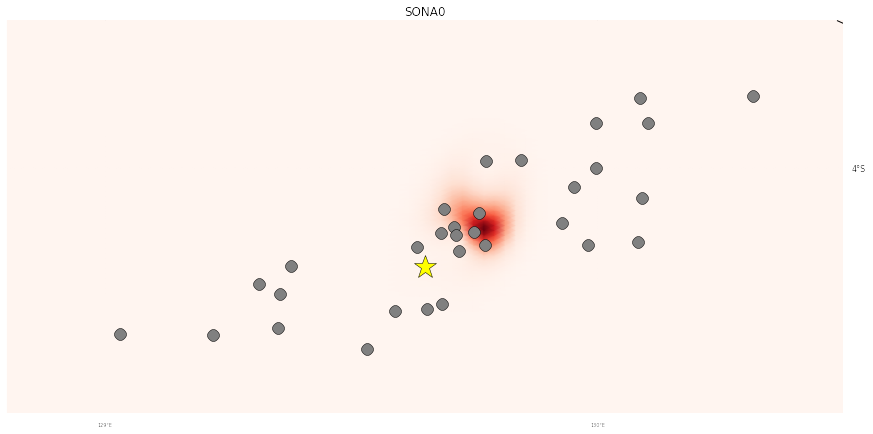

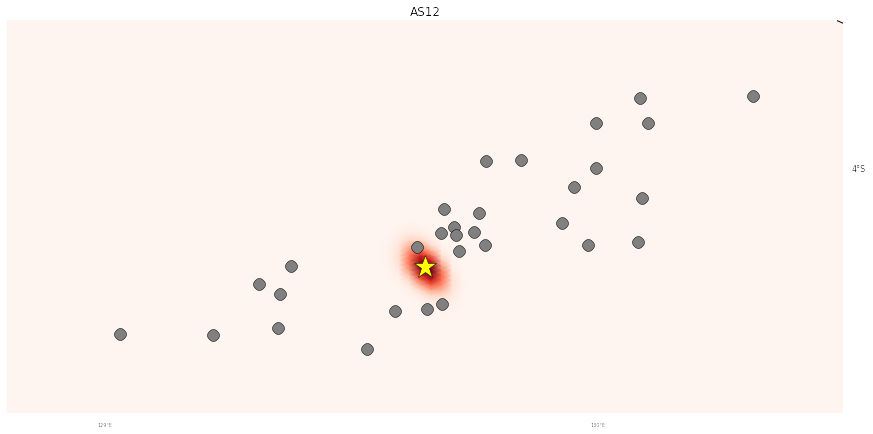

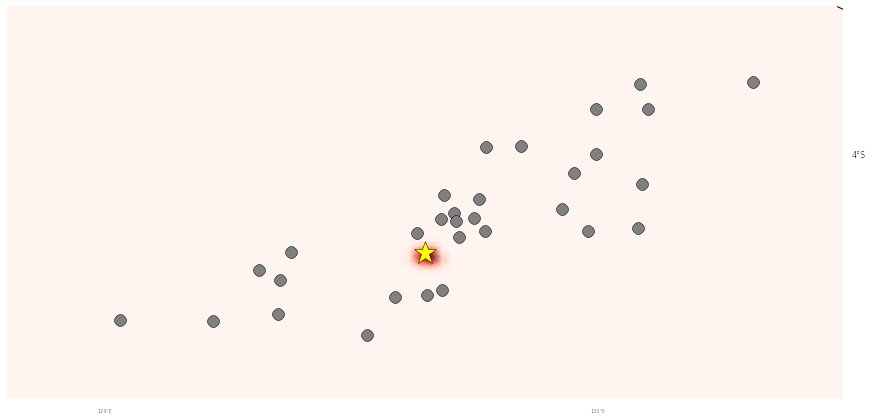

In [9]:
nv=0.3 
sv=0.3
ls=10.0
n=80
hms = []
hm_full = None

fff = lambda v, fv : np.exp((v - np.max(fv))/2.0)
for sta in sg_joint.station_waves.keys():
    try:        
        hm = generate_heatmap(nv=nv, sv=sv, ls=ls, sta=sta, n=n, fname=sta+"80.map")
        ax = plot_hm(hm, colorbar=False, f_preprocess=[fff,], cm="Reds")
        ax.set_title(sta)
        hms.append(hm)
        if hm_full is None:
            hm_full = hm
        else:
            hm_full = hm_full + hm
    except Exception as e:
        print e
        continue
        
plot_hm(hm_full, colorbar=False, f_preprocess=[fff,], cm="Reds")

['ZAA0', 'CM16', 'BVA0', 'INK', 'AKTO', 'MK31', 'FITZ', 'CTA', 'WR1', 'SONA0', 'AS12', 'KURBB']
could not combine event locations: need more than 0 values to unpack
could not combine event locations: need more than 0 values to unpack
could not combine event locations: need more than 0 values to unpack


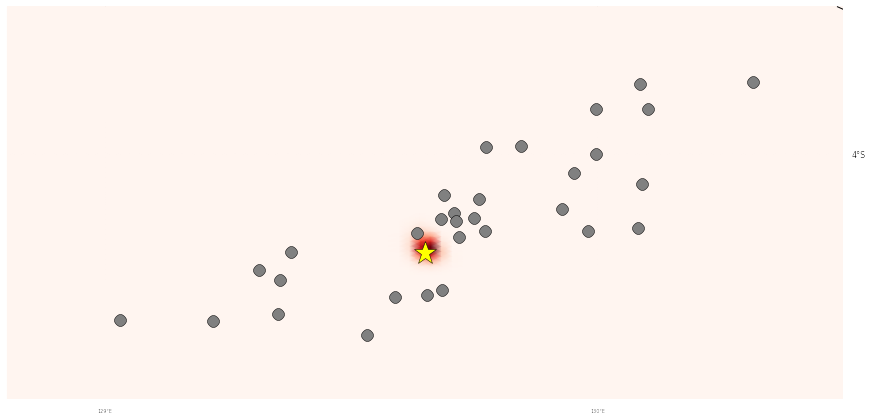

In [16]:
print sg_joint.station_waves.keys()
#print len(hms)

mkar = hms[4]
cmar = hms[1]
fitz = hms[5]
asar = hms[9]
ttl = mkar + cmar + fitz+asar
plot_hm(ttl, colorbar=False, f_preprocess=[fff,], cm="Reds")

In [ ]:

hm1 = generate_heatmap(nv=nv, sv=sv, ls=ls, sta="MK31", n=n)
plot_hm(hm1)
hm2 = generate_heatmap(nv=nv, sv=sv, ls=ls, sta="AS12", n=n)
plot_hm(hm2)
hm4 = generate_heatmap(nv=nv, sv=sv, ls=ls, sta="CM16", n=n)
plot_hm(hm4)

hm = hm1 + hm2 + hm4

plot_hm(hm)


(128.80000000000001, 130.5, -4.5, -3.6999999999999997)

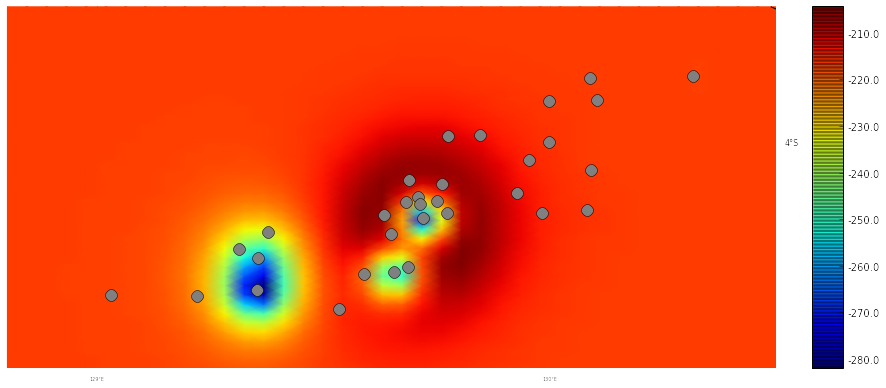

In [68]:
hm = EventHeatmap(f=gpll, n=40, left_lon=128.8, right_lon=130.5, bottom_lat=-4.5, top_lat=-3.7, calc=True)


#hm.add_reference_events(locations=locs, covs=[])


f = plt.figure(figsize=(15, 15))
ax = f.add_subplot(111)
hm.plot(axes=ax, smooth= True)
hm.plot_locations(locs, marker="o", ms=12,  yvals=None, alpha=1.0, mfc="gray")
ax.set_title("")
ax.axis("off")


In [73]:
wn1 = sg_joint.get_arrival_wn(sta, dbl1, "P", "freq_0.8_4.5", chan)
hm1, hp1 = compute_wavelet_messages(sg_joint, wn1)
wn2 = sg_joint.get_arrival_wn(sta, dbl2, "P", "freq_0.8_4.5", chan)
hm2, hp2 = compute_wavelet_messages(sg_joint, wn2)


holdout_posterior1 = hp1.values()[0]
holdout_messages1 = hm1.values()[0]
holdout_posterior2 = hp2.values()[0]
holdout_messages2 = hm2.values()[0]

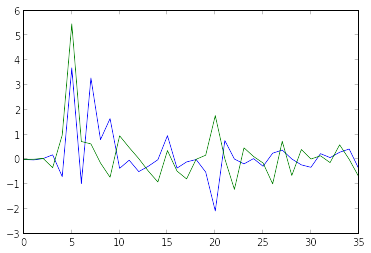

In [74]:
plot(holdout_posterior1[0][:36])
plot(holdout_posterior2[0][:36])